In [48]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from sklearn import metrics
%matplotlib inline
plt.style.use('ggplot')

In [55]:
def read_dataset(filePath,delimiter=','):
    data = genfromtxt(filePath, delimiter=delimiter)
    features, labels = np.array(data[:,0:-1], dtype=float), np.array(data[:,-1],dtype=int)
    return features,labels

def feature_normalize(features):
    mu = np.mean(features,axis=0)
    sigma = np.std(features,axis=0)
    return (features - mu)/sigma

def append_bias_reshape(features):
    n_training_samples, n_dim  = features.shape[0], features.shape[1]
    features = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    return features

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

def plot_points(features,labels):
    normal = np.where(labels == 0)
    outliers = np.where(labels == 1)
    fig = plt.figure(figsize=(10,8))
    plt.plot(features[normal ,0],features[normal ,1],'bx')
    plt.plot(features[outliers,0],features[outliers ,1],'ro')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    plt.show()

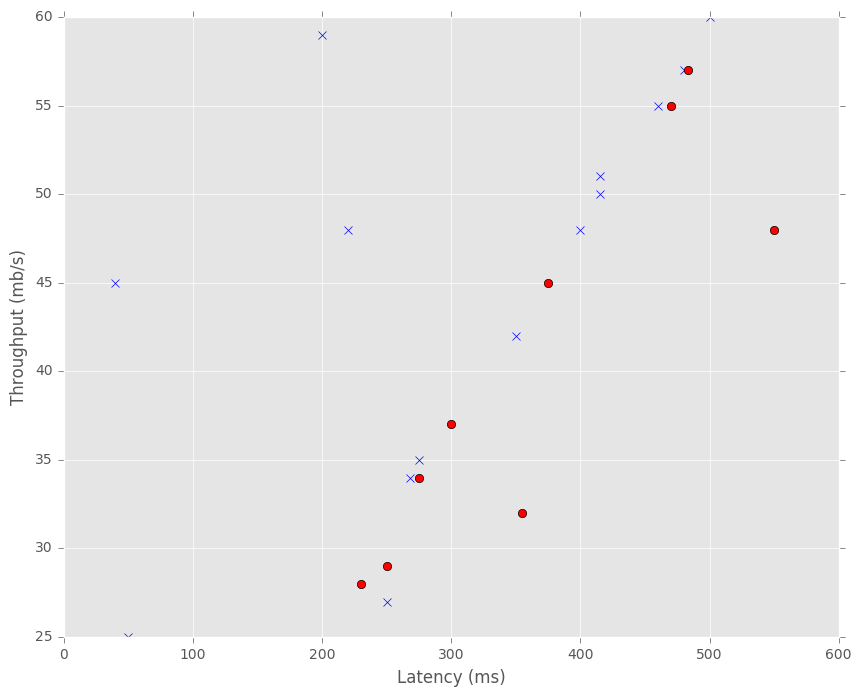

In [71]:
features,labels = read_dataset('LOGISTICREGRESSION_DATASET.csv')
normalized_features = feature_normalize(features)
plot_points(features,labels)

In [72]:
features = append_bias_reshape(features)
one_hot_labels = one_hot_encode(labels)

In [73]:
n_dim = features.shape[1]
rnd_indices = np.random.rand(len(features)) < 0.70

train_x = features[rnd_indices]
train_y = one_hot_labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = one_hot_labels[~rnd_indices]

In [113]:
learning_rate = 0.00001
training_epochs = 100

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,2])
W = tf.Variable(tf.ones([n_dim,2]))
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [116]:
y_ = tf.nn.sigmoid(tf.matmul(X,W))
cost_function = tf.nn.l2_loss(y_-Y,name="Squared_Error_Cost") 
#tf.reduce_mean(tf.reduce_sum((-Y * tf.log(y_)) - ((1 - Y) * tf.log(1 - y_)), reduction_indices=[1]))
#tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

Accuracy:  0.5


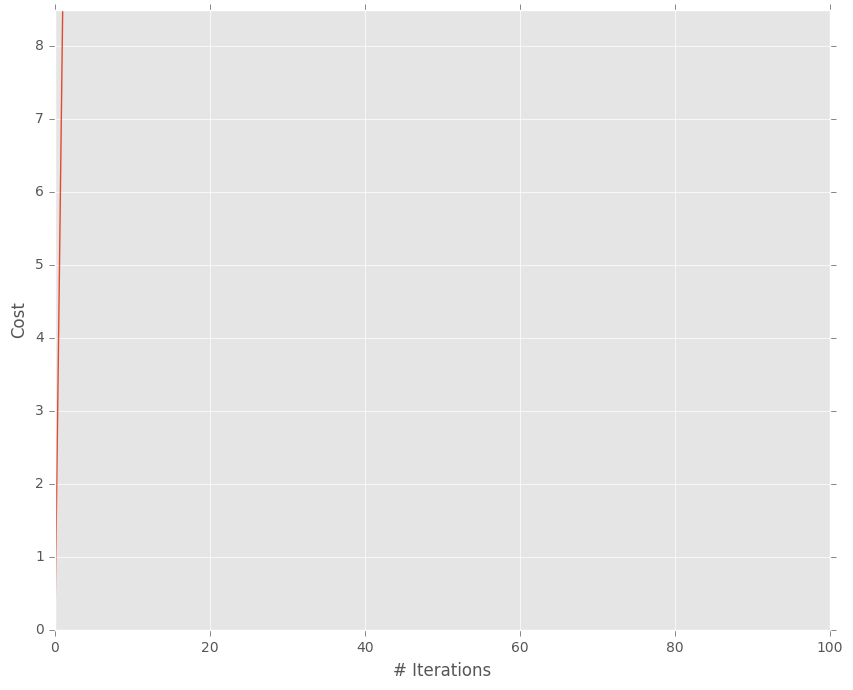

In [117]:
cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        sess.run(optimizer,feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,sess.run(cost_function,feed_dict={X: train_x,Y: train_y}))
    
    y_pred = sess.run(y_ , feed_dict={X: test_x})
    correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print ("Accuracy: ",(sess.run(accuracy, feed_dict={X: test_x, Y: test_y})))
    
    #plot cost
    fig = plt.figure(figsize=(10,8))
    plt.plot(cost_history)
    #print(cost_history)
    plt.axis([0,training_epochs,0,np.max(cost_history)])
    plt.xlabel('# Iterations')
    plt.ylabel('Cost')
    plt.show()